## Mask R-CNN for Pantograph Pose Estimation
---

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Add root to path 
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

# Import Mask RCNN
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.model import utils


tools = os.path.abspath("../../")
tools = tools+'/coco-master/PythonAPI'
if tools not in sys.path:
    sys.path.append(tools)
    
# for i in sys.path:
#     print(i)

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

# Import pantogrograph class
from dev import pantograph

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "models")

# Set path to root of images. 
DATA_DIR = os.path.join(ROOT_DIR, "datasets/pantograph")

print("Using Root dir:",ROOT_DIR)
print("Using Model dir:",MODEL_DIR)
print("Using Data dir:",DATA_DIR)

Using TensorFlow backend.


I've been imported
Using Root dir: /home/jupyter/GCP_Test
Using Model dir: /home/jupyter/GCP_Test/models
Using Data dir: /home/jupyter/GCP_Test/datasets/pantograph


In [2]:
import json
# Write json to file
def WriteJSON(obj,filename):
    try:
        with open(filename, 'w') as outfile:
#             obj_json = json.dumps(obj, sort_keys=True, indent=4,default=str)
            obj_json = json.dumps(obj, cls=NumpyArrayEncoder)
            outfile.write(obj_json)
    except Exception as e:
        print(e)
        print('File not written.')

# Read and return json object from file. If none, return empty object.
def ReadJSON(filename):
    try: 
        with open(filename) as f:
            obj = json.loads(f.read())
    except Exception as e: 
        obj = [] 
    return obj

In [3]:
# Compute Shortest path pixel distance between actual/pred
def ComputeEuclDistance(test_row,pred_row):
    return round(math.sqrt((test_row[0]-pred_row[0])**2+(test_row[1]-pred_row[1])**2), 2)
#     return round(math.sqrt((test_row['X']-pred_row['X'])**2+(test_row['Y']-pred_row['Y'])**2), 2)

# Compute absolute pixel distance between actual/pred
def ComputeABSDistance(test_row,pred_row):
    return abs(test_row['X']-pred_row['X'])+abs(test_row['Y']-pred_row['Y'])

In [4]:
def CreateTESTINGTable(image_id,keypoints,t_type):
    kp_names = ['L1','L2','L3','R3','R2','R1']

    cat_names = {
        0:'FB',
        1:'MB',
        2:'RB'
    }

    coll = []
    print('Incoming kp size:',keypoints.shape)
    for i in range(0,keypoints.shape[2]):
    #     print('i:',i)
        for j in range(0,keypoints.shape[1]):
    #         print('\t j:',j)
            x,y = list(keypoints[i][j])[:2]

            tmp = {
                'image_id':image_id,
                'class':cat_names[i],
                'kp_name':kp_names[j],
                'X':x,
                'Y':y,
                'type':t_type
            }
            coll.append(tmp)
            
    return coll

In [5]:
'''
Create Test and Prediction frames
'''
# REquires each anno to have 3 cats
def CreatePredTable(obj,image_ids):
    cat_names = {
            0:'FB',
            1:'MB',
            2:'RB'
        }

    pred_results = []
    hits = []
    # Loop through image_ids
    for image_id in image_ids:
        
        try:
        
            # Collect 3 sets of keypoints
            tmp = []
            found = 0
            # Loop through annotations. Stop if we find 3.
            for anno in obj['annotations']:
                # Match image_id and anno image_id
                if image_id == anno['image_id']:
                    found += 1
                    hit = anno['hit']
                    hits.append(hit)
                    kp = np.array(anno['keypoints'])
                    tmp.append(kp)
                if found > 2:
                    break
            # 
            stacked = np.stack(tmp) 
    #         print('Stacked kp shape',stacked.shape)

            pred_results += CreateTable(image_id,stacked,'pred')
        except Exception as e:
            print(e)
    #
    pred = CreateResultFrame(pred_results)
#     print('num hits',len(hits))
    
    shits = []
    for hit in hits:
        for i in range(1,7):
            shits.append(hit)
#     print('num hits',len(shits))
    pred['detection'] = shits
    
    pred = pred[['image_id', 'class', 'detection', 'kp_name', 'X', 'Y', 'V', 'type']]
    
    return pred



def CreateTable(image_id,keypoints,t_type):
#     print('Incoming kp size:',keypoints.shape)
    kp_names = ['L1','L2','L3','R3','R2','R1']

    cat_names = {
        0:'FB',
        1:'MB',
        2:'RB'
    }

    coll = []
#     print(keypoints.shape[0])
    for i in range(0,keypoints.shape[0]):
    #     print('i:',i)
        for j in range(0,keypoints.shape[1]):
    #         print('\t j:',j)
            x,y,v = list(keypoints[i][j])[:] # use 2 for only x,y

            tmp = {
                'image_id':image_id,
                'class':cat_names[i],
                'kp_name':kp_names[j],
                'X':x,
                'Y':y,
                'V':v,
                'type':t_type
            }
            coll.append(tmp)
            
    return coll



def CreateResultTable(image_id,keypoints,r):
    kp_names = ['L1','L2','L3','R3','R2','R1']

    cat_names = {
        0:'FB',
        1:'MB',
        2:'RB'
    }

    coll = []
    for i in range(0,keypoints.shape[0]):
    #     print('i:',i)
        for j in range(0,keypoints.shape[1]):
    #         print('\t j:',j)
            x,y = list(keypoints[i][j])[:2]
            px,py = list(r['keypoints'][i][j])[:2]

            pixelDistance = ComputeEuclDistance(list(keypoints[i][j])[:2],list(r['keypoints'][i][j])[:2])

            tmp = {
                'image_id':image_id,
                'class':cat_names[i],
                'kp_name':kp_names[j],
                'Test_X':x,
                'Test_Y':y,
                'Pred_X':px,
                'Pred_Y':py,
                'PD':pixelDistance
            }
            coll.append(tmp)
            
    return coll


def CreateResultFrame(resultSet):
    df = pd.DataFrame(resultSet)
    cols = ['image_id','class','kp_name', 'X', 'Y','V','type']
    df = df[cols]
    
    return df

## Configurations

Run one of the code blocks below to import and load the configurations to use.

In [6]:
class InferenceConfig(pantograph.PantographConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

config.display()


Configurations Superlee:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        50
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0.5
IMAGE_PADDING                  True
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
KEYPOINT_MASK_POOL_SIZE        7
KEYPOINT_MASK_SHAPE            [56, 56]
KEYPOINT_THRESHOLD             0.005
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES        

## Load Dataset

In [12]:
# Load dataset
dataset = pantograph.PantographDataset()
dataset.load_pantograph(DATA_DIR, "val")#test

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))

for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Skeleton: (5, 2)
Keypoint names: (6,)
Image Count: 30
Class Count: 4
  0. BG                                                
  1. front_bar                                         
  2. middle_bar                                        
  3. rear_bar                                          


In [13]:
'''
Load image ids to match in dataset and pred file
'''

image_ids = dataset.image_ids.tolist()[:]

## Generate Dataframes

In [10]:
TEST_FILE

'/home/jupyter/GCP_Test/datasets/pantograph/val/region_data.json'

In [14]:
'''
Load validation data from file
'''

TEST_FILE = DATA_DIR+'/val/region_data.json' #.replace("val",'train')
obj = ReadJSON(TEST_FILE)

print("Validation Dataset")
print("-----------------")
print("Number of images:\t",len(obj['images']))
print("Number of detections:\t",len(obj['annotations']))

kps = 0
for anno in obj['annotations']:
    kps += anno['num_keypoints']
    
print('Number of keypoints:\t',int(kps))

Validation Dataset
-----------------
Number of images:	 30
Number of detections:	 90
Number of keypoints:	 534


In [10]:
'''
Validation keypoint of interest
'''

print("anno_id  num kp  img_id  class")
for anno in obj['annotations']:
    if anno['num_keypoints'] != 6:
        print(anno['id'],'\t',anno['num_keypoints'],'\t',anno['image_id'],'\t',anno['category_id'])

anno_id  num kp  img_id  class
7 	 5 	 2 	 2
64 	 4 	 21 	 2
73 	 4 	 24 	 2
88 	 5 	 29 	 2


In [ ]:
'''
Validation keypoint of interest
'''

print("anno_id  num kp  img_id  class")
for anno in obj['annotations']:
    if anno['num_keypoints'] != 6:
        print(anno['id'],'\t',anno['num_keypoints'],'\t',anno['image_id'],'\t',anno['category_id'])

In [15]:
'''
Create Test DF
'''

gt_results = []
for image_id in image_ids:
    
    try:
    
        # Load annotations from file
        image, image_meta, class_ids, bbox, masks, keypoints =\
        modellib.load_image_gt_keypoints(dataset, config, 
                               image_id, augment=False,use_mini_mask=True)

        # Get single list 
        gt_results += CreateTable(image_id,keypoints,'test')
        
    except Exception as e:
        print(e)
    
test = CreateResultFrame(gt_results)
test

,image_id,class,kp_name,X,Y,V,type
0,0,FB,L1,218,647,2,test
1,0,FB,L2,307,603,2,test
2,0,FB,L3,325,599,2,test
3,0,FB,R3,733,599,2,test
4,0,FB,R2,751,603,2,test
...,...,...,...,...,...,...,...
535,29,RB,L2,291,730,2,test
536,29,RB,L3,348,722,1,test
537,29,RB,R3,715,717,1,test
538,29,RB,R2,762,725,2,test


In [16]:
test[test['V']==0]

,image_id,class,kp_name,X,Y,V,type
42,2,MB,L1,0,0,0,test
384,21,MB,L1,0,0,0,test
389,21,MB,R1,0,0,0,test
438,24,MB,L1,0,0,0,test
443,24,MB,R1,0,0,0,test
528,29,MB,L1,0,0,0,test


In [17]:
PRED_FILE = DATA_DIR+'/val/pred_region_data.json'
obj = ReadJSON(PRED_FILE)

print("Predicted Dataset")
print("-----------------")
print("Number of images:\t",len(obj['images']))
print("Number of detections:\t",len(obj['annotations']))

kps = 0
for anno in obj['annotations']:
    #print(len(anno['keypoints']))
    kps += len(anno['keypoints'])
    
print('Number of keypoints:\t',kps)

Predicted Dataset
-----------------
Number of images:	 30
Number of detections:	 83
Number of keypoints:	 498


In [18]:
'''
Create pred df
'''

pred = CreatePredTable(obj,image_ids)
pred

,image_id,class,detection,kp_name,X,Y,V,type
0,0,FB,False,L1,165,719,1,pred
1,0,FB,False,L2,217,647,1,pred
2,0,FB,False,L3,321,640,1,pred
3,0,FB,False,R3,738,633,1,pred
4,0,FB,False,R2,790,633,1,pred
...,...,...,...,...,...,...,...,...
493,29,RB,True,L2,282,731,1,pred
494,29,RB,True,L3,365,723,1,pred
495,29,RB,True,R3,694,715,1,pred
496,29,RB,True,R2,736,723,1,pred


In [19]:
pred_by_class = pred[['image_id','class','detection']]
pred_by_class = pred_by_class.groupby(by=['image_id','class']).any()

print("Classification Results")
print("-----------------")
print('Number of correct classifications:  ',len(pred_by_class[pred_by_class['detection']==True]))
print('Number of incorrect classifications:',len(pred_by_class[pred_by_class['detection']==False]))

pred_by_class

Classification Results
-----------------
Number of correct classifications:   49
Number of incorrect classifications: 34


detection
image_id class           
0        FB         False
         MB         False
         RB          True
1        FB          True
         MB          True
...                   ...
28       FB          True
         MB          True
29       FB         False
         MB         False
         RB          True

[83 rows x 1 columns]

In [52]:
tmp = pred_by_class.reset_index()
# tmp = tmp.drop('image_id',axis=1)

In [53]:
tmp.groupby(by=['detection']).count()

,image_id,class
detection,,
False,34,34
True,49,49


In [58]:
t = tmp.groupby(by=['class']).count()


t = t[['detection']]

t=t.rename(columns={'detection':'detections'})
t

,detections
class,
FB,30
MB,30
RB,23


In [60]:
t = tmp.groupby(by=['class','detection']).count()
t=t.rename(columns={'image_id':'detections','detection':'classification'})

# t = t.reset_index()
t

detections
class detection            
FB    False              17
      True               13
MB    False              17
      True               13
RB    True               23

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(x="class", y="image_id", data=t)
# ax = sns.swarmplot(x="class", y="image_id", data=t, color=".25")

In [ ]:
print(len(pred[pred['detection']==True]))
print(len(pred[pred['detection']==False]))

In [25]:
'''
Merge test & pred. Compute PD for each KP.
'''

data = test.merge(pred,on=['image_id','class','kp_name'])

cols = ['image_id', 'class','detection', 'kp_name', 'X_x', 'Y_x', 'V_x', 'type_x', 'X_y', 'Y_y', 'V_y',
       'type_y']

newCols = ['image_id', 'class','detection', 'kp_name', 'test_X', 'test_Y', 'test_V', 'type_x', 'pred_X', 'pred_Y', 'pred_V',
       'type_y']

data = data.rename(columns=dict(zip(cols,newCols)))

cols = ['image_id', 'class','detection', 'kp_name', 'test_X', 'test_Y', 'test_V',  'pred_X', 'pred_Y', 'pred_V']
data = data[cols]

data.reset_index(drop=True)



data['PD'] = -1.0
rows = data.index.tolist()
for i in range(len(rows)):
    row = data.iloc[i]
    
    # Determine PD - Need to add use case for hit == False.
    pd = ComputeEuclDistance([row['test_X'],row['test_Y']],[row['pred_X'],row['pred_Y']])
    
    # Use vis to determine - 
    # test kp vis is 0(-1),
#     if row['test_X'] != -1 and row['test_Y'] != -1:
#         pd = ComputeEuclDistance([row['test_X'],row['test_Y']],[row['pred_X'],row['pred_Y']])
#     # pred kp vis is 0() 
#     elif row['pred_V'] == 0:
#         pass
#     else:
#         pd = -1
    
    # Set PD
    data.at[i,'PD'] = pd

# Keep only hits
misses = data[data['detection'] == False]
# Keep only kp vis match
offKeysA = misses[(misses['test_V'] == 0) & (misses['pred_V'] == 1)].index.tolist()
offKeysB = misses[(misses['test_V'] == 1) & (misses['pred_V'] == 0)].index.tolist()
keys = [i for i in misses.index.tolist() if i not in offKeysA+offKeysB]



# Keep only hits
# data = data[data['detection'] == True]

# Keep only kp vis match
offKeysA = data[(data['test_V'] == 0) & (data['pred_V'] == 1)].index.tolist()
offKeysB = data[(data['test_V'] == 1) & (data['pred_V'] == 0)].index.tolist()
keys = [i for i in data.index.tolist() if i not in offKeysA+offKeysB]


data = data.loc[keys].reset_index(drop=True)

# misses = [i for i in data.index.tolist() if i not in keys]
miss_data_index = offKeysA+offKeysB
# tmp = data.loc[miss_data_index].reset_index(drop=True)

data

,image_id,class,detection,kp_name,test_X,test_Y,test_V,pred_X,pred_Y,pred_V,PD
0,0,FB,False,L1,218,647,2,165,719,1,89.40
1,0,FB,False,L2,307,603,2,217,647,1,100.18
2,0,FB,False,L3,325,599,2,321,640,1,41.19
3,0,FB,False,R3,733,599,2,738,633,1,34.37
4,0,FB,False,R2,751,603,2,790,633,1,49.20
...,...,...,...,...,...,...,...,...,...,...,...
487,29,RB,True,L2,291,730,2,282,731,1,9.06
488,29,RB,True,L3,348,722,1,365,723,1,17.03
489,29,RB,True,R3,715,717,1,694,715,1,21.10
490,29,RB,True,R2,762,725,2,736,723,1,26.08


In [37]:
data = misses

In [ ]:
misses.groupby(by=['image_id']).count()

### Keypoint Pixel Distance Evaluation

In [26]:
data.PD.describe()

count    492.000000
mean      35.418963
std       28.986953
min        0.000000
25%       13.150000
50%       34.190000
75%       49.250000
max      119.750000
Name: PD, dtype: float64

In [42]:
data.PD.describe()

count    291.000000
mean      16.748488
std       13.112395
min        0.000000
25%        5.915000
50%       15.030000
75%       21.010000
max       52.090000
Name: PD, dtype: float64

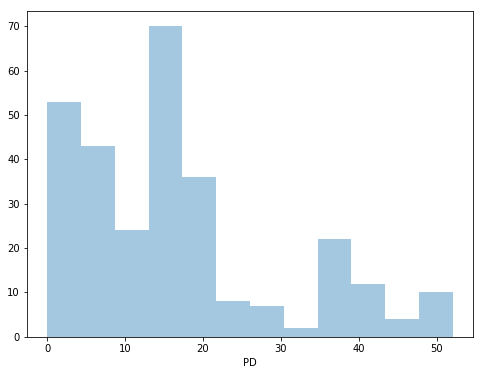

In [43]:
# Distribution of pixel distance for all classes
plt.figure(figsize=(8, 6))
sns.distplot(data["PD"],kde=False)

In [44]:
# PCT match by class

data['class'].value_counts()/test['class'].value_counts()

FB    0.433333
MB    0.416667
RB    0.766667
Name: class, dtype: float64

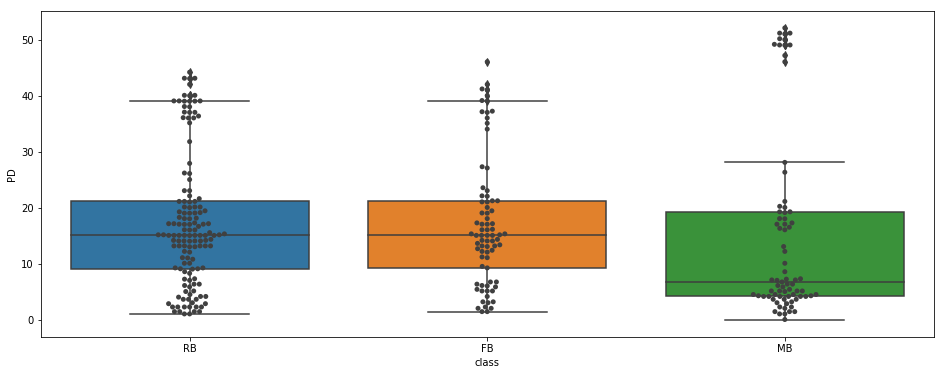

In [45]:
# Distribution of pixel distance by class

plt.figure(figsize=(16, 6))
ax = sns.boxplot(x="class", y="PD", data=data)
ax = sns.swarmplot(x="class", y="PD", data=data, color=".25")

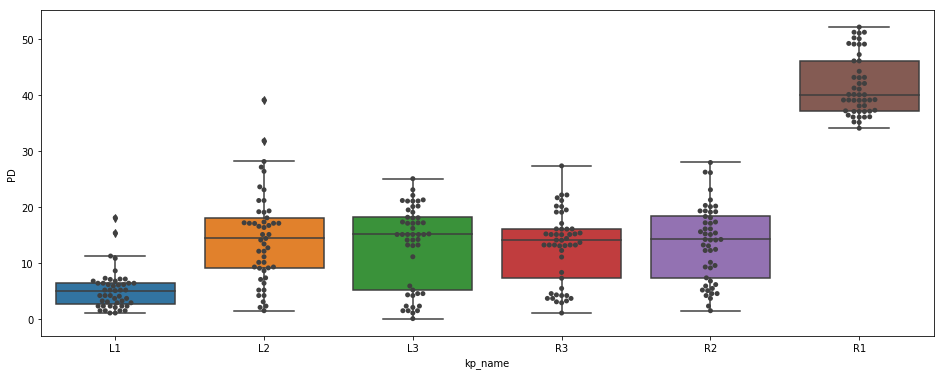

In [46]:
# Distribution of pixel distance by keypoint

plt.figure(figsize=(16, 6))
ax = sns.boxplot(x="kp_name", y="PD", data=data)
ax = sns.swarmplot(x="kp_name", y="PD", data=data, color=".25")

In [47]:
'''
PCT classifications under X pixel away from labeled position
'''

print("PD<= \t Count\t PCGT")
d = []
c = []
p = []
for i in [20,10,5,1]:
    d.append(i)
    c.append(data['PD'].map(lambda x: 1 if x<=i else 0).sum())
    p.append(data['PD'].map(lambda x: 1 if x<=i else 0).sum()/len(data)*100)
    print(i,'\t',data['PD'].map(lambda x: 1 if x<=i else 0).sum(),'\t',":",data['PD'].map(lambda x: 1 if x<=i else 0).sum()/len(data)*100)

PD<= 	 Count	 PCGT
20 	 210 	 : 72.16494845360825
10 	 103 	 : 35.39518900343643
5 	 60 	 : 20.618556701030926
1 	 5 	 : 1.718213058419244


In [ ]:
'''
Mean by class and keypoint
'''

grpd = data.groupby(by=['class','kp_name'])['PD'].mean().to_frame(name='mean').reset_index()
grpd

In [ ]:
data.head()

## Draw Keypoints

In [61]:
'''
Draw labeled and predicted corner points
'''
from PIL import Image
def DrawCorners(data,imgPath,imgID):
#     print(path)

    colors = {
        'FB':'red',
        'MB':'green',
        'RB':'blue',
    }
    
    kp_names = ['L1','L2','L3','R3','R2','R1']

    cat_names = {
        0:'FB',
        1:'MB',
        2:'RB'
    }
    
    figsize = [24,24]
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
#     img = Image.open(imgPath)
    img, image_meta, class_ids, bbox, masks, keypoints =\
    modellib.load_image_gt_keypoints(dataset, config, 
                           imgID, augment=False,use_mini_mask=True)
    
    rows = data.index.tolist()
    for i in rows[:]:
        row = data.iloc[i]
        if row['image_id'] == imgID:
            
            test_circ = plt.Circle((row['test_X'], row['test_Y']), 3.0, facecolor=colors[row['class']]) # , edgecolor=colors[row['class']], color=colors[row['class']]
            ax.add_artist(test_circ)
           
            pred_circ = plt.Circle((row['pred_X'], row['pred_Y']), 3.0, facecolor=None, edgecolor=colors[row['class']],fill=False)
            ax.add_artist(pred_circ)
        

    ax.imshow(img)

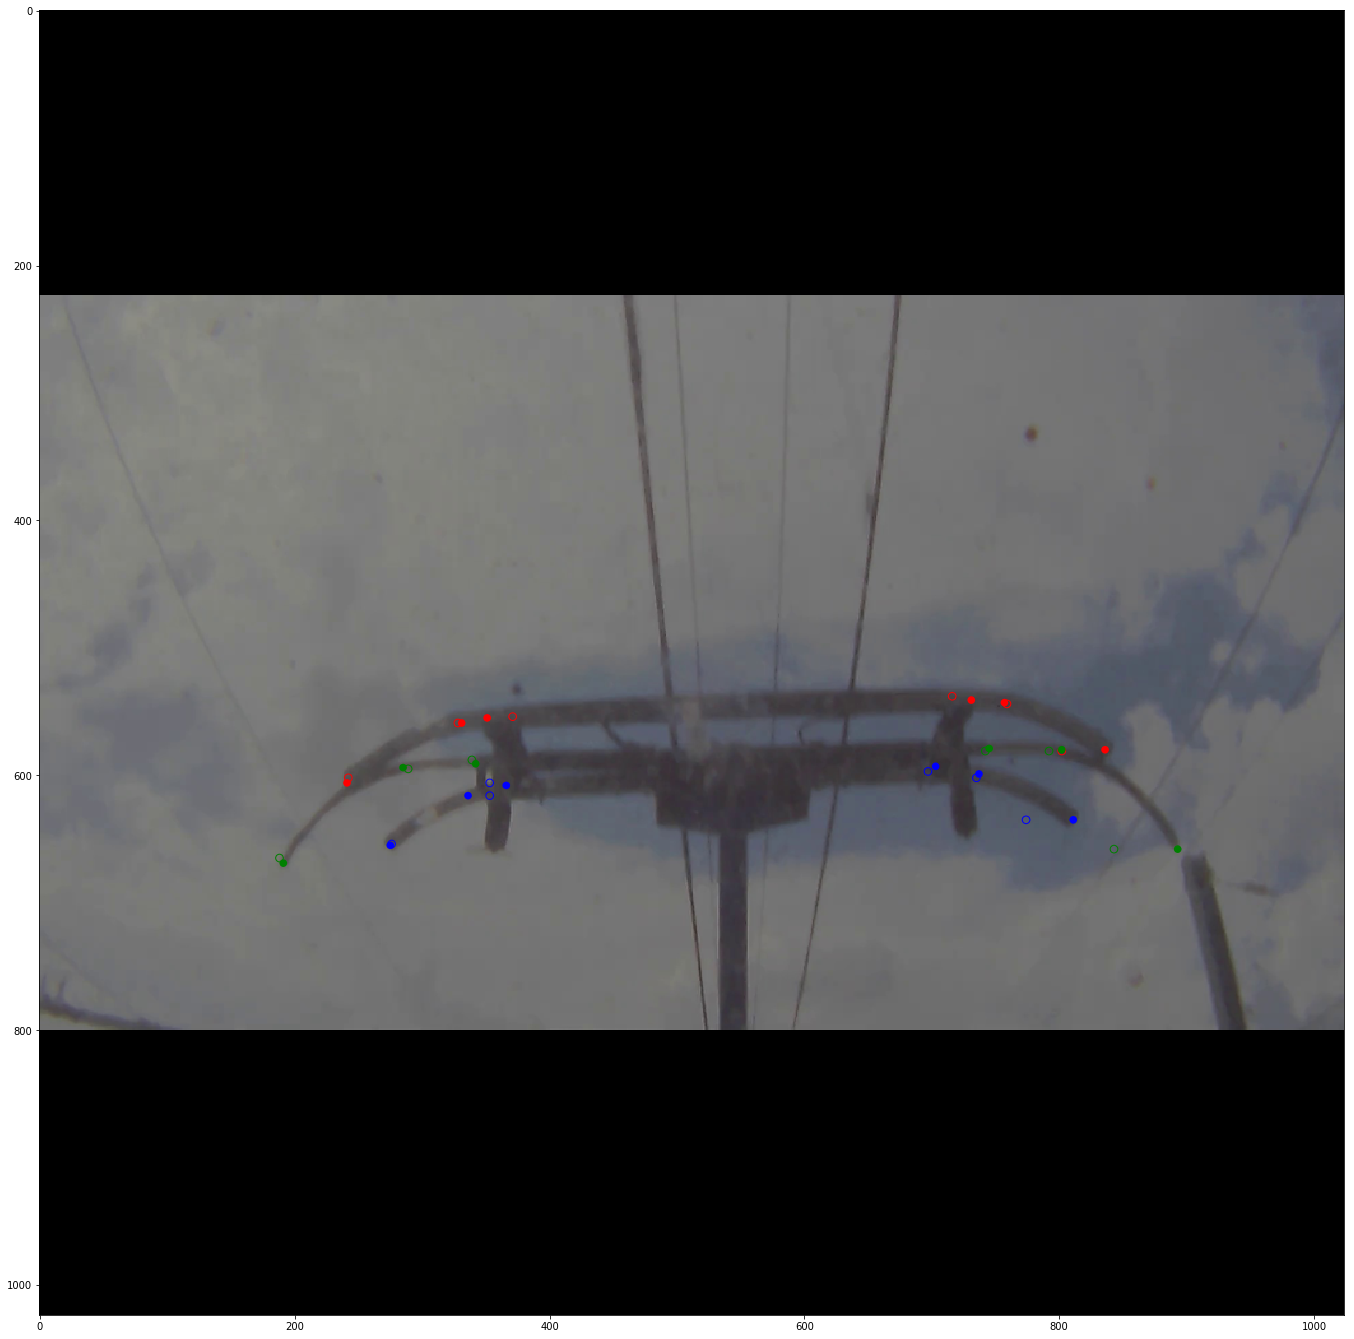

In [67]:
PRED_FILE = DATA_DIR+'/val/pred_region_data.json'
obj = ReadJSON(PRED_FILE)

t = 3
DrawCorners(data,obj['images'][t]['path'],obj['images'][t]['id'])

## COCO Evaluation

## Load Model

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
# Device to load the neural network on. Use CPU to leave GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference" # 'inference' or 'training'

In [ ]:
# Load model using selected device
with tf.device(DEVICE):
    
    # Recreate the model in inference mode
    model = modellib.MaskRCNN(mode="inference", 
                              config=config,
                              model_dir=MODEL_DIR)

    # Set local path to trained weights file
    LOG_DIR = os.path.join(MODEL_DIR, "pantograph20200428T1206")
    MODEL_PATH = os.path.join(LOG_DIR, "mask_rcnn_pantograph_0002.h5")


    # Load trained weights
    model.load_weights(MODEL_PATH, by_name=True)

In [ ]:
pantograph.evaluate_coco(model, dataset, pantograph, eval_type="bbox", limit=0, image_ids=[2])

In [ ]:
mrcnn_class_loss_graph(target_class_ids, pred_class_logits,
                           active_class_ids)

In [ ]:
utils.compute_recall(pred_boxes, gt_boxes, iou):

### Single Image Evaluation

In [ ]:
'''
Load sample image
'''

# Set random image_id
image_id = random.choice(dataset.image_ids)

# Set specific image_id
# image_id = 1

print("image_id ", image_id, dataset.image_reference(image_id))

In [ ]:
'''
Display Ground Truth Test Image
'''

image, image_meta, class_ids, bbox, masks, keypoints =\
    modellib.load_image_gt_keypoints(dataset, config, 
                           image_id, augment=False,use_mini_mask=False) # Set to False to preview original annotation

# How to ensure alignment/where to get classnames, colors, etc??
class_names = [dataset.class_names[1:][i-1] for i in class_ids]
# print(len(class_names),len(dataset.class_names))
 
if masks.shape[0] < image.shape[0]:
    masks = utils.expand_mask(bbox, masks, image.shape)
    
visualize.display_instances(image, bbox, masks, class_ids,dataset.class_names,title="Predictions")
visualize.DrawAnnotations(image,class_ids,class_names,bbox=bbox,masks=masks,keypoints=keypoints,skeleton=dataset.skeleton,figsize=[16,16])

In [ ]:
'''
Run Detection
'''

# Reload to be sure no changes
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run detection and get results
results = model.detect_keypoint([image], verbose=1)
r = results[0] # for one image

# Get class names
class_names = [dataset.class_names[1:][i-1] for i in class_ids]

# Expand masks if needed
if masks.shape[0] < image.shape[0]:
    masks = utils.expand_mask(r['rois'], r['masks'], image.shape)
else:
    masks = r['masks']

In [ ]:
visualize.display_instances(image, r['rois'], masks, r['class_ids'], 
                            dataset.class_names, r['scores'], 
                            title="Predictions")

# Draw vis
visualize.DrawAnnotations(image, 
                          r['class_ids'],
                          class_names=class_names,
                          bbox=r['rois'],
                          masks=masks,
                          keypoints=r['keypoints'],
                          skeleton=dataset.skeleton,
                          scores=r['scores'],
                          figsize=[16,16])

In [ ]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(bbox, class_ids, masks,
                                          r['rois'], r['class_ids'], r['scores'],r['masks'])

visualize.plot_precision_recall(AP, precisions, recalls)

In [ ]:
utils.compute_ap(bbox, class_ids, masks,
               r['rois'], r['class_ids'], r['scores'],r['masks'],
               iou_threshold=0.5)